In [31]:
from dotenv import load_dotenv
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import warnings
import humanize
import missingno as msno
import requests
import os

In [2]:
%matplotlib inline

load_dotenv()

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

In [33]:
response = requests.get('https://gis.transmilenio.gov.co/arcgis/rest/services/Troncal/consulta_estaciones_troncales/FeatureServer/1/query?where=1%3D1&outFields=*&f=json').json()
troncal_transmilenio = pd.DataFrame(response['features'])
troncal_transmilenio = pd.json_normalize(troncal_transmilenio['attributes'])
troncal_transmilenio.head(3)

,objectid,numero_estacion,nombre_estacion,coordenada_x_estacion,coordenada_y_estacion,ubicacion_estacion,troncal_estacion,numero_vagones_estacion,numero_accesos_estacion,biciestacion_estacion,...,longitud_estacion,globalid,created_user,created_date,last_edited_user,last_edited_date,codigo_nodo_estacion,componente_wifi,componente_aplificacion,log_replica
0,116,07001,Perdomo,990294.7280,9.999536e+05,AutoSur-Kr78C,NQS,2,1,0,...,-74.164971,{61AAA51C-F036-4D99-B895-E3DCA2F52D47},None,None,None,None,7001,Valor SI al campo,None,None
1,87,09110,AV. Jiménez - CL 13,999822.3829,1.000757e+06,Calle 13 - caracas,Americas,3,2,0,...,-74.079109,{F4282057-CEBC-431E-9178-602615311D01},None,None,None,None,14003,Valor SI al campo,None,None
2,71,09110,AV. Jiménez - Caracas,999675.9713,1.000738e+06,Calle 13 - Calle 11,Caracas,4,2,0,...,-74.080428,{D830EF50-FC3D-416D-BE9A-9A13550841A3},None,None,None,None,9110,Valor SI al campo,None,None


In [3]:
apartments = pd.read_csv('../../data/processed/apartments.csv')
apartments = apartments[apartments['tipo_operacion'] == 'ARRIENDO']
apartments = apartments.drop(columns=['precio_venta'])
apartments.shape

(9364, 30)

In [4]:
chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.head(3)

,codigo,tipo_propiedad,tipo_operacion,precio_arriendo,area,habitaciones,banos,administracion,parqueaderos,sector,...,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,cerca_estacion_tm
9472,3702-M4422710,APARTAMENTO,ARRIENDO,5500000.0,150.0,2.0,3.0,899000.0,1.0,CHICO,...,1,0,1,0,False,CHAPINERO,S.C. PORCIUNCULA,Calle 72,773.82,0
9473,10139-M4369601,APARTAMENTO,ARRIENDO,8500000.0,105.0,2.0,2.0,NaN,1.0,CHICO,...,0,0,1,0,False,CHAPINERO,S.C. BELLAVISTA,Calle 72,1030.65,0
9474,10139-M4081445,APARTAMENTO,ARRIENDO,15000000.0,265.0,3.0,3.0,1165000.0,3.0,CHICO,...,0,1,1,0,False,CHAPINERO,S.C. BELLAVISTA,Calle 72,1180.91,0


In [5]:
chapinero.shape

(3426, 30)

In [6]:
chapinero = chapinero.drop(chapinero[chapinero['area'] == 0].index)
chapinero.shape

(3419, 30)

In [7]:
chapinero[['precio_arriendo', 'administracion', 'area']].describe().T.applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
precio_arriendo,3.4 thousand,21.6 million,387.6 million,800.0 thousand,3.9 million,6.6 million,11.2 million,20.0 billion
administracion,2.3 thousand,2.5 million,61.9 million,10.0 thousand,606.8 thousand,1.0 million,1.6 million,3.0 billion
area,3.4 thousand,169,111,8,82,148,236,780


# Eliminar Outliers

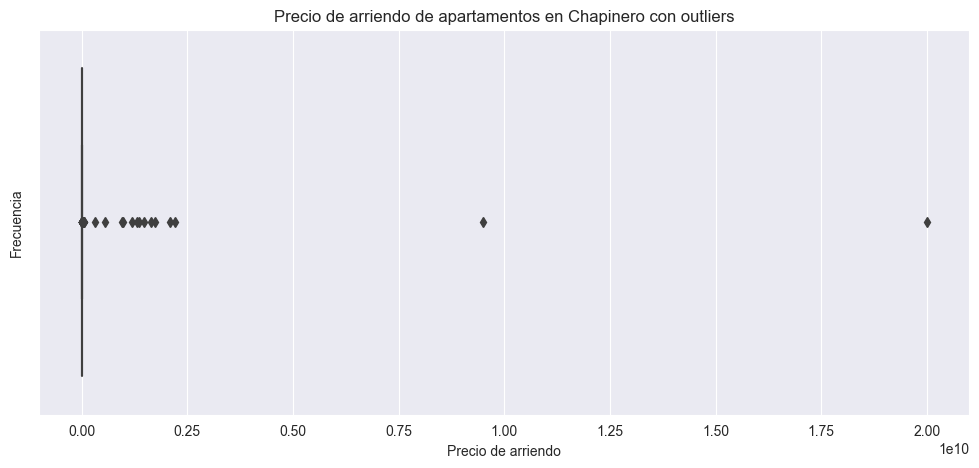

In [8]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    x='precio_arriendo',
    data=chapinero
)

plt.title('Precio de arriendo de apartamentos en Chapinero con outliers')
plt.xlabel('Precio de arriendo')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
iqr = stats.iqr(chapinero['precio_arriendo'])
q1 = np.percentile(chapinero['precio_arriendo'], 25)
q3 = np.percentile(chapinero['precio_arriendo'], 75)

outlier_threshold = 1.5

lower_bound = q1 - (outlier_threshold * iqr)
upper_bound = q3 + (outlier_threshold * iqr)

outliers = chapinero.loc[(chapinero['precio_arriendo'] < lower_bound) | (chapinero['precio_arriendo'] > upper_bound)]
outliers.shape

(136, 30)

In [10]:
outliers['precio_arriendo'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_arriendo,136,358.2 million,1.9 billion,22.2 million,24.0 million,25.1 million,31.3 million,20.0 billion


In [11]:
chapinero = chapinero.drop(outliers.index)
chapinero.drop(chapinero[chapinero['codigo'] == '11301-M4069724'].index, inplace=True)
chapinero.drop(chapinero[chapinero['codigo'] == '4796-3142'].index, inplace=True)
chapinero.shape

(3281, 30)

# Analisis Rapido

In [12]:
chapinero[['precio_arriendo', 'administracion', 'area']].describe().T.applymap(lambda x: humanize.intword(x))

,count,mean,std,min,25%,50%,75%,max
precio_arriendo,3.3 thousand,7.7 million,5.0 million,800.0 thousand,3.8 million,6.5 million,10.1 million,22.1 million
administracion,2.2 thousand,2.5 million,63.3 million,10.0 thousand,600.0 thousand,1.0 million,1.6 million,3.0 billion
area,3.3 thousand,161,103,8,80,140,221,730


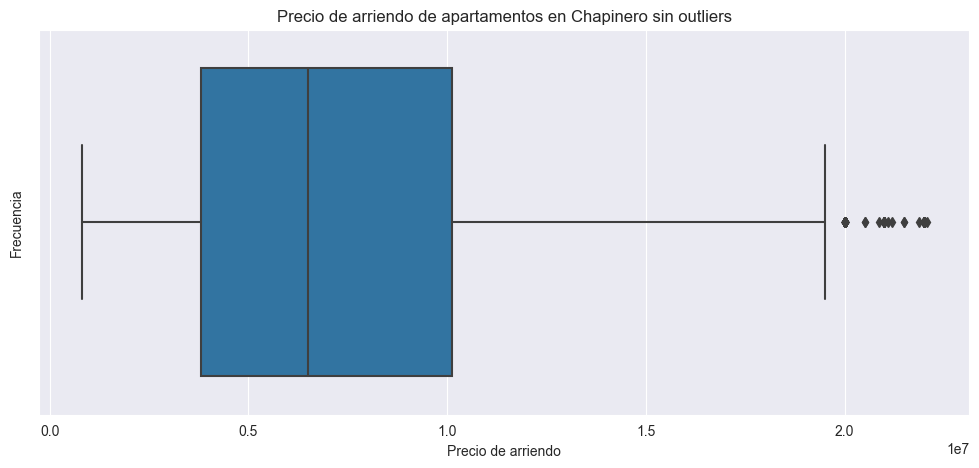

In [13]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    x='precio_arriendo',
    data=chapinero
)

plt.title('Precio de arriendo de apartamentos en Chapinero sin outliers')
plt.xlabel('Precio de arriendo')
plt.ylabel('Frecuencia')
plt.show()

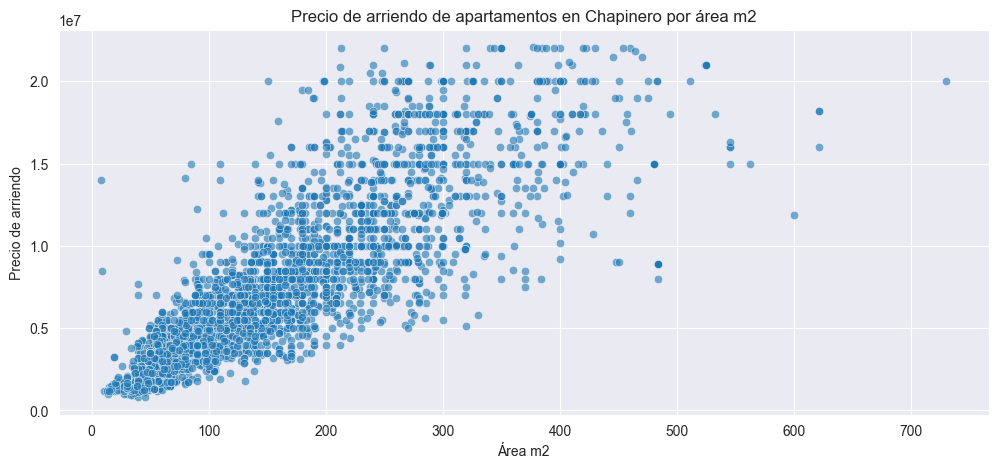

In [14]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x='area',
    y='precio_arriendo',
    data=chapinero,
    alpha=0.6,
)

plt.title('Precio de arriendo de apartamentos en Chapinero por área m2')
plt.xlabel('Área m2')
plt.ylabel('Precio de arriendo')
plt.show()

In [16]:
fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_arriendo',
    # size='area',
    size_max=15,
    zoom=12,
    hover_name='barrio',
    hover_data=['area', 'estrato', 'habitaciones', 'banos', 'parqueaderos', 'administracion', 'precio_arriendo', 'codigo'],
    color_continuous_scale=px.colors.sequential.Viridis,
    height=600,
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    # title='Precio de arriendo por barrio en Chapinero',
)

fig.show()

In [20]:
fig = ff.create_hexbin_mapbox(
    data_frame=chapinero,
    lat='latitud',
    lon='longitud',
    nx_hexagon=12,
    opacity=.6,
    min_count=1,
    labels={'color': 'Precio de arriendo'},
    color='precio_arriendo',
    color_continuous_scale=px.colors.sequential.Viridis,
    zoom=12,
    height=600,
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

In [21]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_arriendo', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'estado', 'longitud', 'latitud', 'descripcion',
       'jacuzzi', 'piso', 'closets', 'chimenea', 'permite_mascotas',
       'gimnasio', 'ascensor', 'conjunto_cerrado', 'coords_modified',
       'localidad', 'barrio', 'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'cerca_estacion_tm'],
      dtype='object')

In [43]:
fig = ff.create_hexbin_mapbox(
    data_frame=chapinero,
    lat='latitud',
    lon='longitud',
    nx_hexagon=12,
    opacity=.6,
    min_count=1,
    labels={'color': 'Precio de arriendo'},
    color='precio_arriendo',
    color_continuous_scale=px.colors.sequential.Viridis,
    zoom=12,
    height=600,
)

fig.add_trace(
    go.Scattermapbox(
        lat=troncal_transmilenio['latitud_estacion'],
        lon=troncal_transmilenio['longitud_estacion'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='red',
            allowoverlap=True,
        ),
        text=troncal_transmilenio['nombre_estacion'],
        hoverinfo='text',
    )
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()